In [74]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from numpy import sin, cos, sqrt, array, linspace, pi

### Spectrum Fig3
$H_{eff}$

$\Delta_{aL}=520$

$\Delta_{aL}=5000$

\begin{equation} \label{eq:Heff_c} 
     \hat{H}^{eff}_{OptoMech}=-(\Delta +\frac{g^2_{ac}}{\Delta_{al}} ) \hat{a}^{\dagger} \hat{a} + \omega_m \hat{b}^{\dagger} \hat{b} + \alpha (\hat{b}+\hat{b}^{\dagger}) - g_{eff} \hat{a}^{\dagger}\hat{a}(\hat{b}+\hat{b}^{\dagger}) - iF_L (\hat{a}^\dagger-\hat{a} )
\end{equation}

$$
\alpha = g_{am} (1-\frac{g_{ac}^2}{\Delta_{aL}^2}) , ~~~~~ g_{eff} = g_{cm} + 2 \frac{g_{am}g_{ac}^2}{\Delta_{aL}^2}
$$

$$
\Delta = \omega_L - \omega_c     , ~~~~~ \Delta_{aL}= \omega_a - \omega_L
$$

#### Displaced H 
$
\hat{b}_n = \hat{b} + \alpha/\omega_m
$

$
\hat{b}^{\dagger}_n = \hat{b}^{\dagger} + \alpha/\omega_m
$

\begin{equation} \label{eq:Heff_c2} 
     \hat{H}^{eff}_{D}=-(\Delta +\frac{g^2_{ac}}{\Delta_{aL}} - \frac{2 \alpha g_{eff}}{\omega_m} ) \hat{a}^{\dagger} \hat{a} + 
     \omega_m \hat{b}_n^{\dagger} \hat{b}_n  - g_{eff} \hat{a}^{\dagger}\hat{a}(\hat{b}_n+\hat{b}^{\dagger}_n) - iF_L (\hat{a}^\dagger-\hat{a} )
\end{equation}

In [75]:
def calculate_H(Displaced, w_m, w_a, w_L , Delta_aL, g_cm, g_am, g_ac, g_eff,gamma, kappa, F_L, n_th):
    N = 6                  # number of cavity fock states
    M = 11                  # number of phonon fock states 
    
    #alpha = g_am * (1-(g_ac/Delta_aL)**2) 
    alpha = - (g_eff-g_cm)/2.

    
    a = tensor(destroy(N), qeye(M))
    b = tensor(qeye(N), destroy(M))
    num_a = a.dag() * a 
    num_b = b.dag() * b
    
    c_ops = []
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is mechanical resonator
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))

    ###### Displaced Hamiltoninan or not displaced?
    if (Displaced == 1): 
        #### zero detuning
        w_c  = w_L +(g_ac**2)/Delta_aL - (2*alpha)*g_eff/w_m
        
        Heff_Cav = - (w_L- w_c + (g_ac**2)/Delta_aL- (2*alpha)*g_eff/w_m) *num_a
        H_bextra  = 0  
        H_0      =  - (alpha**2)/w_m
    else:
        w_c  = w_L +(g_ac**2)/Delta_aL 
        
        Heff_Cav  = - (w_L- w_c + (g_ac**2)/Delta_aL ) *num_a   # 
        H_bextra =  alpha * (b + b.dag())
        H_0 =  0
    
    Heff_Mech =  w_m * num_b + H_bextra
    H_drive   =  - 1j* F_L *(a.dag()-a)      
    Heff_Int  =  - g_eff * num_a *(b + b.dag())

    ##### Total H 
    H = H_0 + Heff_Cav + Heff_Mech + Heff_Int + H_drive
    # H0: at resonance and for g=0
    H0 = 0 * H_0 + 0 * Heff_Cav + Heff_Mech + 0* Heff_Int + H_drive   # H at resonance
    
    return H, H0, c_ops, a # , n_0

### Parameters

In [76]:
Displaced = 10        #### displaced Hamiltoninan?  1 ------> YES
Set = 3               ##### set of Parametrs    

if (Set==1):
    w_a  = 105      #[ 1500 ]   [1052  ]
    w_L  =  100 
    g_am = 0.5         #[  50   ]  [.54    ] 
    g_ac =  5   
elif Set==2:
    w_a  = 1500      #[ 15000 ]  [10520  ]
    w_L =  1000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  50
elif Set==3: 
    w_a  = 15000      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  500    
    
w_m  = 1                       # mechanical frequency
n_th_i   = [0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
#kappa_i  = [0.2 * w_m, w_m/10., w_m/20.]     # kappa is cavity decay rate
kappa_i  = [2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.001 * w_m 


In [41]:
Delta_aL = w_a - w_L
w_c  = w_L +(g_ac**2)/Delta_aL

alpha = g_am * (1-(g_ac/Delta_aL)**2) 
shift = g_ac**2/Delta_aL
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
g_eff
#alpha
shift


50.0

### Figures

100%|██████████| 3/3 [00:33<00:00, 11.25s/it]


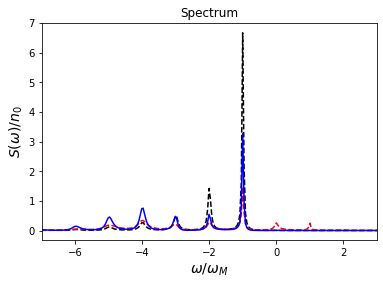

In [81]:
N=6
M=11

fig, ax= plt.subplots(1,1,figsize=(6,4))
solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
# only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
use_rcm = False
linestyle =['--','--','-']
color=['black', 'r', 'b']

tlist = np.linspace(0, 150, 10000)
#wlist = np.linspace(-7, 8, 1000) * w_m
opt = Options(nsteps=10000)

###### to save date in a txt file
xplot = []                                 #######=====###########====####
pllot3aa  = np.zeros((len(tlist),3))       ############tlist
#pllot4aa  = np.zeros((len(tlist),3))       ############wlist
mean      = np.zeros((len(tlist),3), dtype = complex)      # , dtype = complex
correlat  = np.zeros((len(tlist),3), dtype = complex)     # 
spect_t = np.zeros((len(tlist),3), dtype = complex) 
Delta_aL = w_a - w_L 
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2

for i in tqdm([0,1,2]): #tqdm([0,1,2]): 
    n_th  = n_th_i[i]
    kappa = kappa_i[i]
    F_L   = sqrt(kappa) * 0.01   ###0.01
        
    H, H0, c_ops, a = calculate_H(Displaced, w_m, w_a,w_L , Delta_aL, g_cm, g_am, g_ac, g_eff,gamma, kappa, F_L, n_th)    
    #rho = tensor(basis(N,1),basis(M,0))     # basis(2,0) qubit in ground state
    #rho = H.groundstate()[1]
    #rho = tensor(coherent(N,0.1j),coherent(M,0.25j) )
    
    ### n_0    
    #rho0     = steadystate(H0, c_ops, method=solvers[2] , tol=1e-15)
    #n0       = mesolve(H0, rho0, tlist, c_ops, [a.dag() * a]).expect[0]  #, options=opt
    #n_0      = n0[-1]    
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
   
    ##########################  # calculate |<a(t)>|^2
    rho      = steadystate(H, c_ops, method=solvers[1] , tol=1e-12)
    n        = mesolve(H, rho, tlist, c_ops, [a], options= opt).expect[0]
    mean_a_t = np.abs(n)**2 
    mean[: , i]  = mean_a_t
        
    #corr      = correlation_ss(H, tlist, c_ops, a.dag(), a) ##### solver='me'
    corr      = correlation_2op_1t(H, rho, tlist, c_ops, a.dag(), a, options= opt)
    correlat[: , i]  = corr

    spect_t[:, i] = corr - mean_a_t                             #### to substract constantant derive peak 
    spect_tot = corr - mean_a_t
    wlist, spec = spectrum_correlation_fft(tlist, spect_tot )

    ##########################
    #spec = spectrum(H, wlist, c_ops, a.dag(), a)               ##### needs a huge storage!
    ########################
    #### save data 
    xplot = wlist                             ###########
    pllot3aa[: , i] = spec/n_0                 ############
    #pllot4aa[: , i] = spec/n_0                 ############
        
    ax.plot(wlist / w_m, spec/n_0 , linestyle =linestyle[i], color=color[i])  # /n_0    
ax.set_xlabel(r'$\omega/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$ S(\omega) /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Spectrum')
ax.set_xlim([-7*w_m,3*w_m])
#ax.set_ylim([0,2.5])   # ([0,max(spec)])

plt.savefig("Spectrum_eff_33bNoDis15000.pdf", dpi=150)
plt.show()

100%|██████████| 3/3 [00:33<00:00, 11.16s/it]


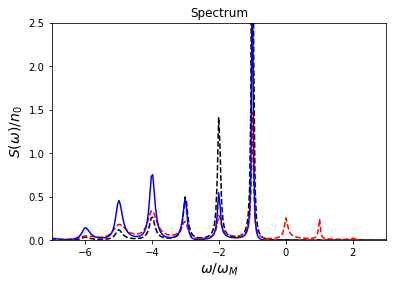

In [53]:
fig, ax= plt.subplots(1,1,figsize=(6,4))
solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
# only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
use_rcm = False
linestyle =['--','--','-']
color=['black', 'r', 'b']

tlist = np.linspace(0, 150, 10000)
#wlist = np.linspace(-7, 8, 1000) * w_m

###### to save date in a txt file
xplot = []                                 #######=====###########====####
pllot3aa  = np.zeros((len(tlist),3))       ############tlist
#pllot4aa  = np.zeros((len(tlist),3))       ############wlist
mean      = np.zeros((len(tlist),3))
correlat1  = np.zeros((len(tlist),3), dtype = complex)

Delta_aL = w_a - w_L 
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2

for i in tqdm([0,1,2]): #tqdm([0,1,2]): 
    n_th  = n_th_i[i]
    kappa = kappa_i[i]
    F_L   = sqrt(kappa) * 0.01   ###0.01
        
    H, H0, c_ops, a = calculate_H(Displaced, w_m, w_a,w_L , Delta_aL, g_cm, g_am, g_ac, g_eff,gamma, kappa, F_L, n_th)    
    
    ### n_0    
    #rho0     = steadystate(H0, c_ops, method=solvers[2] , tol=1e-15)
    #n0       = mesolve(H0, rho0, tlist, c_ops, [a.dag() * a]).expect[0]  #, options=opt
    #n_0      = n0[-1]    
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
   
    ##########################  # calculate |<a(t)>|^2
    rho      = steadystate(H, c_ops, method=solvers[0] , tol=1e-12)
    n        = mesolve(H, rho, tlist, c_ops, [a]).expect[0]
    mean_a_t = np.abs(n)**2 
    mean[: , i]  = mean_a_t
        
    #corr      = correlation_ss(H, tlist, c_ops, a.dag(), a) ##### solver='me'
    corr      = correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a)
    correlat1[: , i]  = corr

    spect_tot = corr - mean_a_t                             #### to substract constantant derive peak 
    wlist, spec = spectrum_correlation_fft(tlist, spect_tot) 

    ##########################
    #spec = spectrum(H, wlist, c_ops, a.dag(), a)               ##### needs a huge storage!
    ########################
    #### save data 
    xplot = wlist                             ###########
    pllot3aa[: , i] = spec/n_0                 ############
    #pllot4aa[: , i] = spec/n_0                 ############
        
    ax.plot(wlist / w_m, spec/n_0 , linestyle =linestyle[i], color=color[i])  # /n_0    
ax.set_xlabel(r'$\omega/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$ S(\omega) /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Spectrum')
ax.set_xlim([-7*w_m,3*w_m])
ax.set_ylim([0,2.5])   # ([0,max(spec)])


plt.savefig("Spectrum_eff_3bNoDis15000.pdf", dpi=150)
plt.show()

$\Delta_{aL} = 5000$

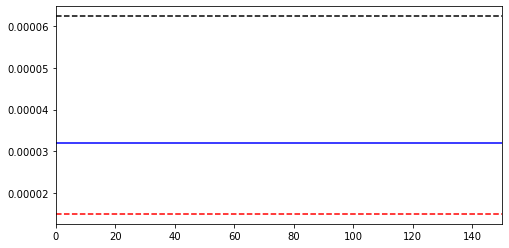

In [31]:
x = tlist
linestyle =['--','--','-']
color=[ 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(8,4))
for i in [0, 1, 2]:
    plt.plot(x, mean[: , i], linestyle = linestyle[i], color = color[i])
    
ax.set_xlim([0,150])
#ax.set_ylim([0,.0001])

plt.savefig("a2_t.pdf", dpi=150)
plt.show()

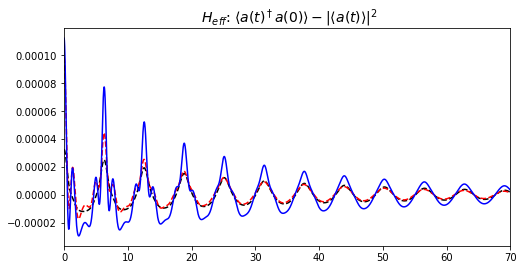

In [92]:
x = tlist
linestyle =['--','--','-']
color=[ 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(8,4))
for i in [0, 1, 2]:
    plt.plot(x, np.real(spect_t[:, i]), linestyle = linestyle[i], color = color[i])
    #ax1.plot(x, mean[: , i], linestyle = linestyle[i], color = color[i], label='A')

ax.set_xlim([0 ,70])
#ax.set_ylim([0,.0001])
ax.set_title(r' $H_{eff}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)  
plt.savefig("correlation_H_eff.pdf", dpi=150)
plt.show()

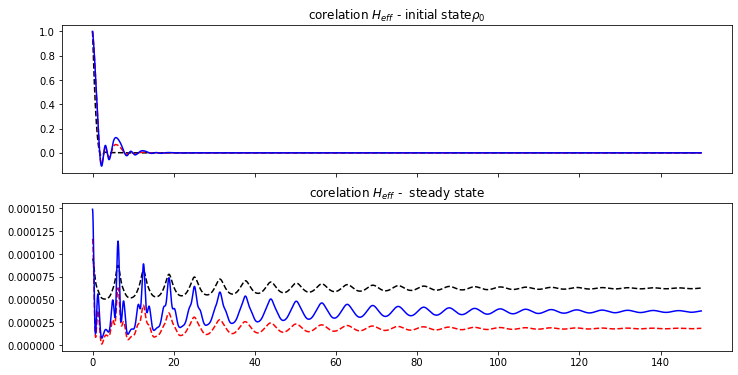

In [73]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))
for i in [0, 1, 2]:

    
    ax[0].plot(x, np.real(correlat[: , i]), linestyle = linestyle[i], color = color[i])
    ax[1].plot(x, np.real(correlat1[: , i]), linestyle = linestyle[i], color = color[i], label='A')
#ax[0].set_xlim([0 ,30])
ax[0].set_title(r'corelation $H_{eff}$ - initial state$\rho_0$')
ax[1].set_title(r'corelation $H_{eff}$ -  steady state')
plt.savefig("correlation_H_eff.pdf", dpi=150)


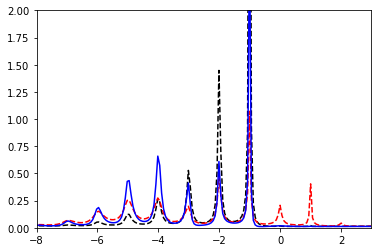

In [28]:

data3aa = np.column_stack([xplot, pllot3aa[: , 0],pllot3aa[: , 1] ,pllot3aa[: , 2]])
np.savetxt("Fig3a15000Modf.txt" , data3aa, fmt=['%s','%s','%s','%s'])

linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(6,4))
for i in [1,2,3]:
    plt.plot(xplot, data3aa[:,i], linestyle = linestyle[i], color = color[i])
    
ax.set_xlim([-8*w_m,3*w_m])
ax.set_ylim([0,2])
plt.savefig("Spectrum_eff_Modif_NoDis_15000.pdf", dpi=150)
plt.show()
